# CLASS_EDE: CLASS for Early Dark Energy

## The EDE Model

Early dark energy can be realized with a scalar field of the following potential,  
  
V($\phi$) = $(mf)^2\left(1 - \cos\left(\frac{\phi}{f}\right)\right)^n + V_\Lambda$,  
  
where $m$ is the axion mass, $f$ the axion decay constant, $\phi$ the scalar field, and $V_\Lambda$ is the cosmological constant. The evolution of the scalar field is governed by the Klein-Gordon equation, here in conformal time,  
  
$\phi'' + 2 a H \phi' + a^2 \frac{dV}{d\phi} = 0$.


## Implementation of EDE in CLASS_EDE

In CLASS_EDE there are two different ways to implement this eary dark energy model. The user can choose to either specify cosmology parameters $f_{EDE}$, the maximum fraction of the total energy density in the field, and $z_c$, the redshift at which this occurs or with particle physics parameters $f_{scf}$, the axion decay constant, and $m_{scf}$, the axion mass. For both implementations the user must also specify $\theta_i$, the axion misalignment angle, and $n$.

The user should take note that the implementation of dark energy, i.e. $\Lambda$, is done differently when using the EDE model. The cosmological constant has been included in the scalar field potential, thus the CLASS parameter *omega_lambda* should be set to zero. This is done so that the shooting algorithm adjusts $\Lambda$ to enforce the budget equation without touching the parameters of the EDE model. When doing runs without EDE, the user should revert to implementing dark energy with *omega_lambda*.

## Running CLASS_EDE by Choosing Particle Physics Parameters $f_{scf}, m_{scf},$ and $\theta_i$

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
matplotlib.rcParams['axes.linewidth'] = 4 
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['axes.labelsize'] = 40
matplotlib.rcParams['xtick.labelsize'] = 30 
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['legend.fontsize'] = 30

One can, as in standard CLASS, set values for various parameters as follows.

In [2]:
M = Class()
M.set({'h': .7219,
       'A_s': 2.215e-09,
       'n_s': 0.9889,
       'omega_b': 0.02253,
       'omega_cdm': 0.1306,
       'tau_reio': 0.072,
       'N_ncdm': 1,
       'N_ur': 2.0328})

True

The next block of code is an example of how to implement EDE. Firstly, recall that the cosmological constant is included in the potential of the scalar field. We do this so that it is the quantity which is tuned when trying to match the budget equation. The various parameters for the scalar field potential have been added as separate variables (abandoning *scf_parameters* for easy interface with MCMC). Note, however, you must still specify *scf_parameters*. Any parameters you pass to it will not be used.

In [3]:
M.set({'Omega_Lambda':0,
       'Omega_fld':0,
       'Omega_scf':-1,
       'scf_parameters':'1, 1, 1, 1, 1, 0.0',
       'scf_tuning_index':3,
       'attractor_ic_scf':'no',
       'output':'tCl pCl lCl',
       'n_scf':3, 
       'CC_scf':1,
       'f_scf': np.power(10,26.59913),
       'm_scf': np.power(10,-27.28708),
       'thetai_scf': 2.83})

True

In addition to selecting *f_scf* and *m_scf* as input variables, the user can also specify *log10f_scf* and *log10m_scf*.

We can now run CLASS and extract the backgrounds.

In [4]:
M.compute()
baM = M.get_background()

You can access background quatities of interest using the same syntax as stock CLASS. Some relevant changes include the addition of a new background quantity *V_e_scf*. This corresponds to the scalar field potential - i.e. without $\Lambda$.

In [5]:
fEDE = M.fEDE()
z_c = M.z_c()
baH = baM['H [1/Mpc]']
baT = baM['conf. time [Mpc]']
baa = 1/(1 + baM['z'])
bV = baM['V_e_scf']
bpp = baM["phi'_scf"]
baCrit = baM['(.)rho_crit']

We can now look at some quantities of interest. Below we plot the energy density of the scalar field as a function of redshift.

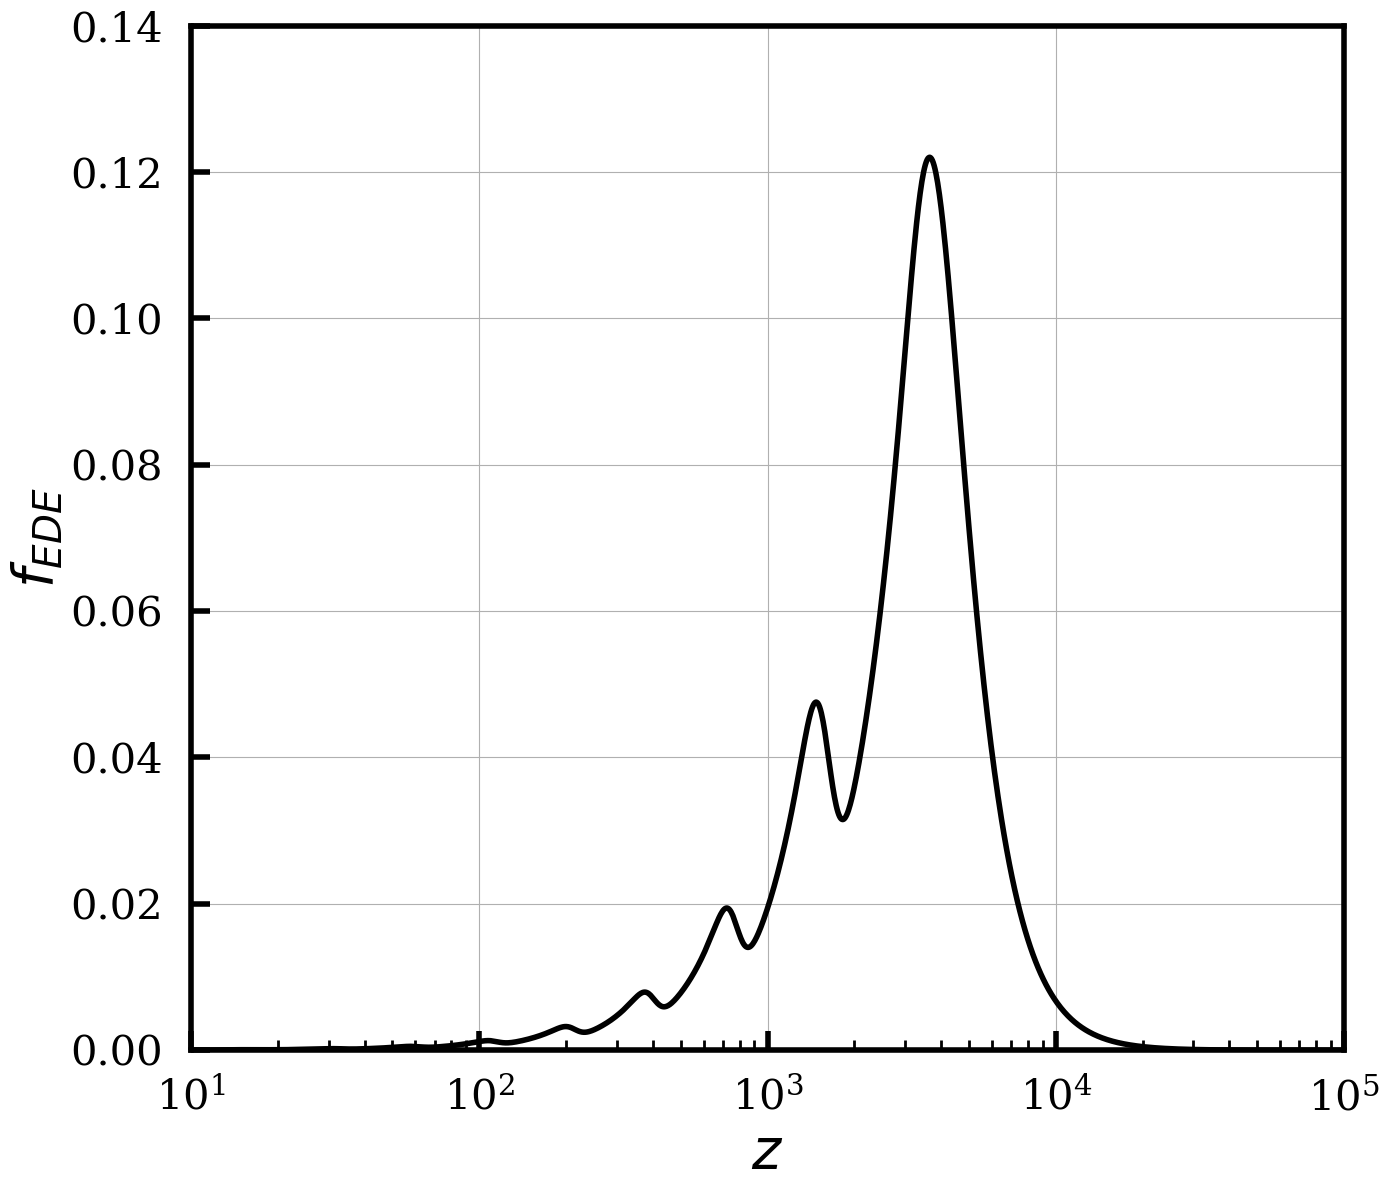

In [6]:
rho_scf = (bpp*bpp/(2*baa*baa) + bV)/3. #energy density in CLASS units

plt.figure(figsize=(14,12))
plt.xscale('log')
plt.xlim([10,1e5])
plt.ylim([0,0.14])
plt.xlabel('$z$')
plt.ylabel(r'$f_{EDE}$')
plt.grid()
plt.plot(baM['z'],rho_scf/baCrit,lw=4,c='k')
plt.tick_params(which='major',axis='x', length=14, width=4, direction='in')
plt.tick_params(which='minor',axis='x', length=7, width=2, direction='in')
plt.tick_params(which='major',axis='y', length=14, width=4, direction='in')
plt.tick_params(pad=20)
plt.tight_layout()
plt.savefig('../figures-for-paper/scf/fEDE-example.pdf')

It is also interesting to look at the equation of state for the field,

$w_\phi = \frac{\frac{1}{2}\left(\phi' \right)^2 - V\left(\phi \right)}{\frac{1}{2}\left(\phi' \right)^2 + V\left(\phi \right)}$.

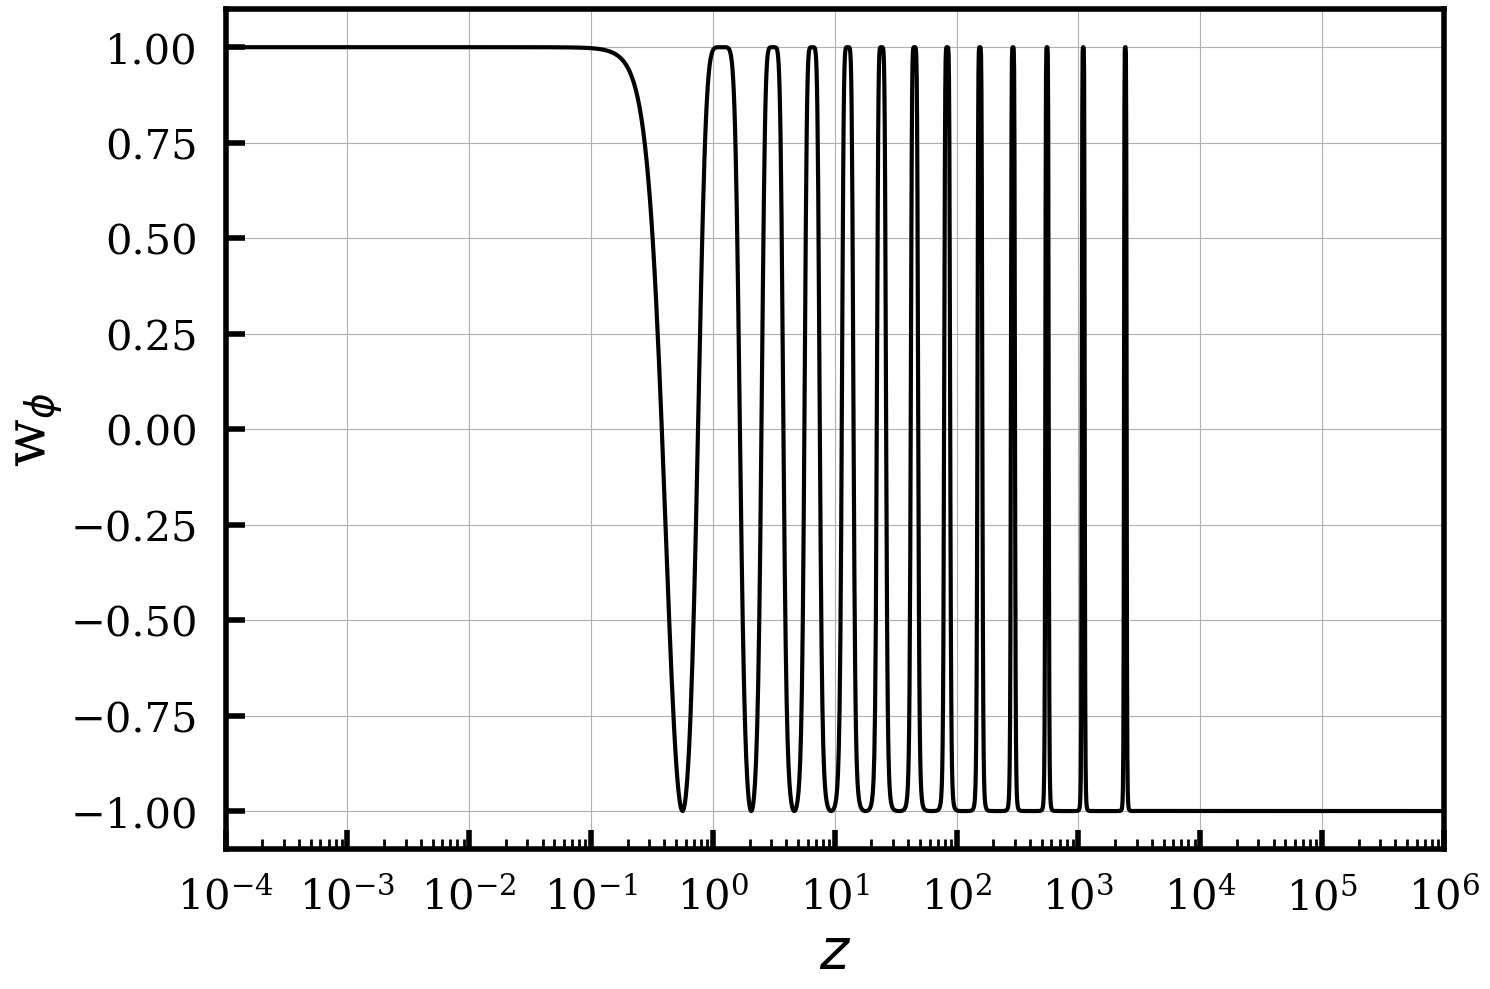

In [7]:
plt.figure(figsize=(15,10))
plt.xscale('log')
plt.xlim([1e-4,1e6])
plt.xlabel('$z$')
plt.ylabel(r'w$_\phi$')
plt.grid()
plt.plot(baM['z'],(0.5*bpp**2 - bV)/(0.5*bpp**2 + bV),lw=3,c='k')
plt.tick_params(which='major',axis='x', length=14, width=4, direction='in')
plt.tick_params(which='minor',axis='x', length=7, width=2, direction='in')
plt.tick_params(which='major',axis='y', length=14, width=4, direction='in')
plt.tick_params(pad=20)
plt.tight_layout()

## Running CLASS_EDE by Choosing $f_{EDE}$ and $z_c$

One can also run CLASS_EDE by specifying maximum fraction of the total energy density in the field, $f_{EDE}$, and the redshift at which this occurs, $z_c$. The particle physics paramters for the scalar field are then determined using a shooting algorithm. Note that this is the same method that was used in [Smith et al.](https://arxiv.org/abs/1908.06995) to implement EDE. A future notebook goes over the effective priors for $f_{scf}$ and $m_{scf}$ when using uniform priors on $f_{EDE}$ and $z_c$, and vice versa.

In [8]:
EDE = Class()

def fEDE_priors(classclass,fEDE,log10z_c, thetai_scf):
    classclass.set({'h': .7219,
             'log10z_c': log10z_c, 
             'fEDE': fEDE,
             'thetai_scf': thetai_scf,
             'A_s': 2.215e-09,
             'n_s': 0.9889,
             'omega_b': 0.02253,
             'omega_cdm': 0.1306,
             'm_ncdm': 0.06,
             'tau_reio': 0.072,
             'N_ncdm':1,
             'N_ur':2.0328,
             'Omega_Lambda':0.0,
             'Omega_fld':0,
             'Omega_scf':-1,
             'n_scf':3,
             'CC_scf':1,
             'scf_parameters':'1, 1, 1, 1, 1, 0.0',
             'scf_tuning_index':3, 
             'attractor_ic_scf':'no'})
    classclass.compute()

Printing the values for fEDE and log10z_c, we see they match those we requested up to subleading digits.

In [9]:
fEDE_priors(EDE,0.122,3.562,2.83)

print('fEDE=', EDE.fEDE())
print('log10z_c=', EDE.log10z_c())
print('log10f_scf = ', EDE.log10f_scf())
print('log10m_scf = ', EDE.log10m_scf())
print('thetai_scf = ', EDE.thetai_scf())

fEDE= 0.12199975295605582
log10z_c= 3.5620013443938774
log10f_scf =  26.59915
log10m_scf =  -27.28737
thetai_scf =  2.83


In [ ]:
baEDE = EDE.get_background()
baH = baEDE['H [1/Mpc]']
baT = baEDE['conf. time [Mpc]']
baa = 1/(1 + baEDE['z'])
bV = baEDE['V_e_scf']
bpp = baEDE["phi'_scf"]
baCrit = baEDE['(.)rho_crit']
rho_scf = (bpp*bpp/(2*baa*baa) + bV)/3.

In [ ]:
plt.figure(figsize=(14,14))
plt.xscale('log')
plt.xlim([10,1e5])
plt.ylim([0,0.14])
plt.xlabel('$z$')
plt.ylabel(r'$f_{{\rm EDE}}$')
plt.plot(baEDE['z'],rho_scf/baCrit,lw=4,c='k')
plt.tick_params(which='major',axis='x', length=14, width=4, direction='in')
plt.tick_params(which='minor',axis='x', length=7, width=2, direction='in')
plt.tick_params(which='major',axis='y', length=14, width=4, direction='in')
plt.tick_params(pad=20)
plt.tight_layout()
plt.grid()

## Standard $\Lambda$CDM Run With CLASS_EDE

The implemenation of $\Lambda$CDM is exactly the same as that used in normal CLASS. Simply remove the portions of the code that implement the scalar field. You may now also adjust the *omega_lambda* parameter directly as $\Lambda$ is no longer also present in the scalar field potential.

In [ ]:
LCDM_settings = {'output':'tCl,pCl,lCl,mPk',
                 'lensing':'yes',
                 'h':0.6821,
                 'omega_b':0.02253,
                 'omega_cdm':0.1177,
                 'A_s':2.216e-9,
                 'n_s':0.9686,
                 'tau_reio':0.085,
                 'm_ncdm': 0.06,
                 'N_ncdm':1, 
                 'N_ur':2.0328,
                 'l_max_scalars':2508,
                 'non linear':'HMcode',
                 'P_k_max_h/Mpc':100,
                 'z_max_pk':3.}

In [ ]:
LCDM = Class()
LCDM.set(LCDM_settings)
LCDM.compute()

You can now acess the power spectrum, background values, and other observables with the same functunality as in standard CLASS.

In [ ]:
baLCDM = LCDM.get_background()

plt.figure(figsize=(15,15))

plt.plot(baEDE['conf. time [Mpc]'],baEDE['H [1/Mpc]'],lw=4,c='k')
plt.yscale('log')
plt.ylim([1e-4,100])
plt.xlim([0,12000])
plt.ylabel(r'H [Mpc$^{-1}$]')
plt.xlabel(r'$\eta$ [Mpc]')
plt.tick_params(which='major',axis='x', length=14, width=4, direction='in')
plt.tick_params(which='minor',axis='x', length=7, width=2, direction='in')
plt.tick_params(which='major',axis='y', length=14, width=4, direction='in')
plt.tick_params(which='minor',axis='y', length=7, width=2, direction='in')
plt.tick_params(pad=20)
plt.tight_layout()
plt.grid()